<a href="https://colab.research.google.com/github/simonians/tesis-economia-fce-unc/blob/colab-project/forcasting_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock market forcasting using LSTM Recurrent Neural Networks 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

## Part 1: Data preparing

Primero definimos los tickers que utilizaremos a lo largo del proyecto. Para la estimación y pruebas de la performance de la red, elegiremos 4 tickers de algunas de las empresas más grandes e importantes de diferentes industrias. Los tickers seleccionados son: 
- GOOGL => Google de la industria tecnológica
- JPM => JPMorgan Chase & Co. de la indsutria bancaria
- MCD => McDonald's de la industria de comida rápida y real estate
- HYG => iShares iBoxx $ High Yield Corporate Bond ETF es un ETF que busca replicar los resultados de inversión de un índice compuesto por bonos corporativos de alto rendimiento denominados en dólares de EE.UU.

In [ ]:
DEFAULT_TICKERS = ['GOOG', 'JPM', 'MCD', "HYG"]
START, END = "2010-01-01", "2020-01-01"

Para las estimaciones trabajaremos con los precios ajustados (adj close).
**"The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions."**

In [ ]:
# Use load_ticker to load the ticker information sent as parameter and the industry information price
def load_ticker(ticker, industry='SPY', start=START, end=END):
    ticker_data = yf.download(ticker, start=start, end=end)
    
    ticker_data = ticker_data[['Close', 'Volume', 'High', 'Low']].rename(columns={'Close': 'Close_Price_%s' % (ticker), 'Volume': 'Volume', 'High': 'High_Price', 'Low': 'Low_Price'}) 
    industry_data = yf.download(industry, start=START, end=END)[['Close']].rename(columns={'Close': 'Close_Price_%s'% (industry)})
    ticker_data = pd.merge(ticker_data, industry_data, how='left', on='Date')
    return ticker_data

# Nix returns a list without the VALUE sent as parameter
def nix(value, list):
    return [x for x in list if x!=value]

In [ ]:
def calculate_sma(days, df, ticker):
  sma_df = df['Close_Price_%s' % (ticker)].rolling(window=days).mean().to_frame()
  return sma_df.rename(columns={'Close_Price_%s' % (ticker):'%s_sma' % (ticker)})

In [ ]:
def calculate_rsi(df, ticker):
    delta = df['Close_Price_%s' % (ticker)].diff()
    positive = delta.clip(lower=0)
    negative = -delta.clip(upper=0)
    ema_positive = positive.ewm(alpha=1/14, min_periods=14).mean()
    ema_negative = negative.ewm(alpha=1/14, min_periods=14).mean()
    rsi = 100 - 100 / (1 + ema_positive / ema_negative)
    rsi = rsi.to_frame()
    return rsi.rename(columns={'Close_Price_%s' % (ticker):'%s_rsi' % (ticker)})

In [ ]:
ticker = 'JPM'
jpm = load_ticker(ticker)
jpm_rsi = calculate_rsi(jpm, "JPM")
jpm_sma = calculate_sma(20, jpm, "JPM")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
from functools import reduce

def merge_dfs(dfs_list):
  merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs_list)
  return merged_df.dropna()

In [ ]:
jpm_final = merge_dfs([jpm, jpm_rsi, jpm_sma])

## Part 2: Data processing

### Parte 1: División conjunto de entrenamiento y test

Primer punto es la separación del total de datos en un conjunto de entrenamiento y uno para testeo / pruebas. Para esto definimos una función que recibe como parámetro el dataframe a separar y un valor (entre 0-1) que representa el porcentaje del df que queremos utilizar para entrenamiento.

In [ ]:
def train_test_split(df, percentage_for_training=0.8):
  if percentage_for_training<0 or percentage_for_training>1:
    #LANZAR UNA EXCEPCIÓN
    print("Acá lanzar excepción")
    return
  # Cálculo del índice correspondiente al 80% de las filas
  index_percentage = int(len(df) * percentage_for_training)

  # División del DataFrame en dos partes: entrenamiento y prueba
  train_df = df[:index_percentage]
  test_df = df[index_percentage:]
  return train_df, test_df

In [ ]:
jpm_train, jpm_test = train_test_split(jpm_final)

### Parte 2: Feature scaling

Normalización del df de entrenamiento. Creamos una función que retornará, para cada fila del df pasado por parámetro, el valor valor normalizado, es decir:
  - Para cada columna de la fila del df, restarle el mínimo y devidirlo por la diferencia entre el maximo y el mínimo del conjunto (de la columna bajo análisis).
Para esto, creamos una función que la denominamos normalization(), que recibe por parámetro un dataframe a normalizar. Utiliza como método de normalización el MinMaxScaler de la librería sklearn.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalization(df):
  sc = MinMaxScaler(feature_range = (0, 1))
  return sc.fit_transform(df)

In [ ]:
training_set_scaled = normalization(jpm_train)

In [ ]:
jpm_train

,Close_Price_JPM,Volume,High_Price,Low_Price,Close_Price_SPY,JPM_rsi,JPM_sma
Date,,,,,,,
2010-02-01,39.630001,37408200,39.930000,38.950001,109.059998,35.773063,42.0985
2010-02-02,40.549999,45968500,40.680000,39.700001,110.379997,43.244476,41.9835
2010-02-03,40.290001,37373300,41.099998,40.169998,109.830002,41.765795,41.8140
2010-02-04,38.349998,57211800,39.919998,38.349998,106.440002,32.763543,41.5355
2010-02-05,38.299999,75224100,38.880001,37.029999,106.660004,32.568703,41.2110
...,...,...,...,...,...,...,...
2017-12-28,107.790001,7440600,107.839996,107.160004,267.869995,64.567063,106.1580
2017-12-29,106.940002,8925700,108.279999,106.940002,266.859985,59.642311,106.2790
2018-01-02,107.949997,13578800,108.019997,106.809998,268.769989,63.231037,106.4370


### Parte 3: Creatring data structure - feature matrix and target vector

Al crear la estructura de datos lo que hacemos es crear dos arrays, X_train, y_train, donde:
- X_train => es un vector de tantos elementos como el conjunto de entrenamiento, donde cada elemento representa 60 jornadas previas operadas que se utilizarán como input para el calculo del output del precio de la jornada estimada. Entre los inputs se encuentra el precio de cierre, volumen operado, precio máximo de la jornada, precio mínimo de la jornada, precio de cierre del SPY, el valor del RSI y SMA.  
- y_train => array donde cada elemento representa el valor del precio de la acción en la jornada estimada, es decir el precio de cierre del día siguiente para cada fila del conjunto de entrenamiento

In [ ]:
def feature_matrix_target_vector_split(training_set):
    X_train = []
    y_train = []
    timesteps = 60
    total_times = len(training_set)
    for step in range(timesteps, total_times):
        X_train.append(training_set[step-timesteps:step, :]) # appendo los 60 valores de las variables independientes previas al precio que estoy estimando
        y_train.append(training_set[step, 0]) # appendo el precio de la estimación
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [ ]:
jpm_X_train, jpm_y_train = feature_matrix_target_vector_split(training_set_scaled)

In [ ]:
print(jpm_X_train)

[[[0.13947436 0.15789306 0.13349816 ... 0.04049348 0.27580986 0.1460035 ]
  [0.15088024 0.19796671 0.14276887 ... 0.04828523 0.38058118 0.14448229]
  [0.14765685 0.15772968 0.14796044 ... 0.0450387  0.35984569 0.14224015]
  ...
  [0.20530621 0.13484029 0.19703338 ... 0.11575469 0.46931523 0.19234102]
  [0.19228862 0.18355194 0.19381956 ... 0.11303939 0.37229119 0.19159364]
  [0.17394    0.29312705 0.18838071 ... 0.09609827 0.26772371 0.18997321]]

 [[0.15088024 0.19796671 0.14276887 ... 0.04828523 0.38058118 0.14448229]
  [0.14765685 0.15772968 0.14796044 ... 0.0450387  0.35984569 0.14224015]
  [0.12360525 0.25060038 0.13337452 ... 0.02502807 0.23360747 0.13855617]
  ...
  [0.19228862 0.18355194 0.19381956 ... 0.11303939 0.37229119 0.19159364]
  [0.17394    0.29312705 0.18838071 ... 0.09609827 0.26772371 0.18997321]
  [0.18695759 0.21018687 0.1802225  ... 0.10141079 0.37480307 0.18923244]]

 [[0.14765685 0.15772968 0.14796044 ... 0.0450387  0.35984569 0.14224015]
  [0.12360525 0.250600

In [ ]:
print(jpm_y_train)

[0.18695759 0.19365237 0.17604764 ... 0.98648644 0.98785019 1.        ]


### Parte 4: Reshaping data

El objetivo de esta sección es transformar los valores de entrada y salida (matríz de características y el vector de etiquetas) en un formato adecuado para poder ser procesdos por la red. Así en nuestro caso tendremos lo siguiente:
- La matriz de características (jpm_X_train) debe tener tres dimensiones: número de observaciones, timestep y número de variables de entrada. En este caso, tenemos X_train con forma (número de observaciones, 60, 7) que representa la información de las 60 jornadas previas con 7 variables de entrada para cada observación.
- La matriz de etiquetas (jpm_y_train) debe tener dos dimensiones: número de observaciones y número de variables de salida. En este caso, tenemos y_train con forma (número de observaciones, 1) que representa el valor del precio de cierre para cada observación.

In [ ]:
jpm_X_train = np.reshape(jpm_X_train, (jpm_X_train.shape[0], jpm_X_train.shape[1], 7))
reshapingMsg = "Reshaping feature matrix.\nThe first value is the batch size, the second value is the timesteps and the third value is the indicators.\n   jpm_X_train.shape[0] = {shape_cero} \n   jpm_X_train.shape[1] = {shape_one}\n   jpm_X_train.shape[2] = {shape_two}".format(shape_cero=jpm_X_train.shape[0], shape_one = jpm_X_train.shape[1], shape_two=jpm_X_train.shape[2])
print(f"{reshapingMsg}")

Reshaping feature matrix.
The first value is the batch size, the second value is the timesteps and the third value is the indicators.
   jpm_X_train.shape[0] = 1937 
   jpm_X_train.shape[1] = 60
   jpm_X_train.shape[2] = 7


In [ ]:
jpm_y_train = np.reshape(jpm_y_train, (jpm_y_train.shape[0], 1))
reshapingMsg = "Reshaping target vector.\nThe first value is the batch size and the second is the number of outputs.\n   jpm_y_train.shape[0] = {shape_cero} \n   jpm_y_train.shape[1] = {shape_one}".format(shape_cero=jpm_y_train.shape[0], shape_one = jpm_y_train.shape[1])
print(f"{reshapingMsg}")

Reshaping target vector.
The first value is the batch size and the second is the number of outputs.
   jpm_y_train.shape[0] = 1937 
   jpm_y_train.shape[1] = 1


## Part 3: Building the RNN

### First step: Importing libraries

Para la construcción de la arquitectura de nuestra RNN importaremos: 


*   Sequential => Nos permitirá crear un objeto de red neuronal que simule una secuencia de capas (hidden layers)
*   Dense => Es la clase que permite confeccionar la capa de salida (output layer). Es una fully connected layer y nos permite ajustar la salida de la red al tamaño deseado.
*   LSTM => Para añadir las capas LSTM. 
*   Dropout => Regularización de droput, usado para evitar el overfitting. 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Second step: Initialising the RNN

El regressor es un objeto de una capa Secuencial. A diferencia de las ANN o CNN, en RNN a este objeto lo llamamos Regressor y no Clasificator porque lo que buscamos es predecir un valor continuo (en nuestro caso el precio de una acción) y no una clasificación de objetos.

In [ ]:
regressor = Sequential()

### Third step: Adding the first hidden layer

El paso siguiente es añadir la primera capa a la secuencia de capas definidas previamente (junto con un poco de regularización para evitar el overfitting). 
Esta primera capa será una LSTM layer. Sobre esta primera capa deberemos definir:

*   El primer argumento es el número de unidades de memoria (más conocidas como neuronas) que tendrá la primera capa. Como captar las tendencias de la cotización de una acción es bastante complejo, necesitaremos tener una alta dimensionalidad y por ende un alto numero de neuronas en cada una de las capas LSTM. Por esta razón el número elegido será 50. De utilizar un número bajo de neuronas (por ej 5) no serían bien captados los movimientos ascendentes y descendentes del precio de las acciones. 
*   El segundo es un booleano (return_sequences) que básicamente indica si habrá una nueva capa LSTM próxima, por ende lo colocaremos en TRUE (utlizaremos una red neuronal LSTM apilada o stack neural networks)
*   El tercer parámetro es el input_shape que básciamente es la forma de entrada que se creo con el reshape previo por ende contendrá el número de observaciones, steptimes y las características. 
Luego de agregado de la capa LSTM hay que agregar la regularización de abandono (dropout) que cuenta únicamente con un argumento que es la tasa de dropout y que indica el número de neuronas que se están dispuestas a eliminar para hacer esa regularización (se recominda usar una tasa del 20%) lo que implicará que el 20% de las neuronas, en nuestro caso 10, se dejarán de lado para el forwardpropagation y el backpropagation. Esas neuronas que se eliminan son seleccionadas aleatoriamente. Con esto se busca que la red sea menos sensible a pequeñas perturbaciones y ayuda a prevenir el sobreajuste. Esta técnica ayuda a la red a generalizar mejor los datos de prueba, lo que significa que puede realizar mejores predicciones en datos que no ha visto antes.

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (jpm_X_train.shape[1], jpm_X_train.shape[2])))
regressor.add(Dropout(0.2))

### Fourth step: Adding the rest hidden layers

Como estas son capas intermediasm no hará falta añadir input_layers ya que se añaden automáticamente con el compilado de capas

In [ ]:
hidden_layers_to_add = 2
for i in range(hidden_layers_to_add):
  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

### Fifth step: Adding the last hidden layer 

La última capa sólo se elimina el return_sequences, ya que ahora toma el valor FALSE (valor por defecto) ya que no se añadirá otra LSTM layer sino que únicamente se añadirá una capa de salida. 

In [ ]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Sixth step: Adding output layer

Como capa de salida usamos una fully connected layer porque la capa de salida está totalmente conectada a la última LSTM y usaremos la clase Dense de Keras. 
El argumento que hay que pasar es el número de unidades (units) que básicamente son la cantidad de neuronas. Dado que lo que estamos intentando predecir es un precio, un valor continuo y único, el número de neuronas será igual a la unidad (tiene una única dimensión).

In [ ]:
regressor.add(Dense(units = 1))

### Last step: Compiling the RNN

En la compilación necesitamos elegir el optimizer y la función de pérdida utilizada para calcular el error.

Keras nos surgiere utilizar como algorítmo de optimización RMSProp, pero probando descrubirmos que para nuestro problema una mejor opción era utilizar el algorítmo ADAM (es muy potente y seguro).
En este caso para la loss-function no se utiliza la entropía cruzda, ya que estamos ante un problema de regresión y necesitamos predecir un valor continuo y la loss-function correcta es la mean_squared_error.

El algoritmo de optimización Adam es popular debido a que combina las ventajas del algoritmo de descenso de gradiente estocástico (SGD) y el algoritmo Adagrad. Además, se adapta a la tasa de aprendizaje de forma adaptativa y mantiene una estimación de momento de primer y segundo orden de los gradientes.

La función de pérdida MSE es una buena opción para problemas de regresión ya que penaliza fuertemente las grandes diferencias entre las predicciones y las etiquetas, lo que puede llevar a una mejor convergencia del modelo.

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Part 4: Fitting the RNN

Para el fitting de la red neuronal necesitamos pasar 4 atributos:

- El conjunto de entrenamiento (en nuestor caso la lista de precios de apertura normalizada)
- El segundo atributo son los outputs para el conjunto de entrenamiento, es decir el resultante en T+1 para los 60 valores previamente operados.
- El tercer valor es el número de veces que se presentará todo el conjunto de datos de entrenamiento a la red neuronal durante el entrenamiento. Si el número de épocas es demasiado bajo, la red neuronal puede no haber tenido suficiente tiempo para aprender patrones en los datos. Por otro lado, si el número de épocas es demasiado alto, la red neuronal puede ajustarse demasiado a los datos de entrenamiento y no generalizar bien a los datos nuevos
- Por último para entrenar la red necesitamos definir el batch_size o cantidad de lotes, que se refiere a la cantidad de ejemplos de entrenamiento que se propagan a través de la red neuronal antes de que se actualicen los pesos. Un tamaño de lote demasiado grande puede hacer que la memoria de la computadora se llene y ralentizar el entrenamiento, mientras que un tamaño de lote demasiado pequeño puede hacer que el entrenamiento sea ineficiente.

In [ ]:
regressor.fit(jpm_X_train, jpm_y_train, epochs = 50, batch_size = 40)

## Part 5 - Making predictions

### Step 1: Getting real stock prices 

Para obtener los precios reales del JPM (y los que contrastaremos contra las estimaciones) debemos usar el DF de testeo. La columna que necesitamos es la de precios de cierre ("Close_Price").

In [ ]:
jpm_real_stock_prices = jpm_test.iloc[:,0:1].values

### Step 2: Getting predicted stock prices

In [ ]:
jpm_final_normalizated = normalization(jpm_final)

In [ ]:
len(jpm_final_normalizated)

2497

In [ ]:
inputs = jpm_final_normalizated[len(jpm_final_normalizated) - len(jpm_test) - 60:]


In [ ]:
print(len(jpm_final_normalizated) - len(jpm_test) - 60)

1937


In [ ]:
len(inputs)

560

Para realizar ahora las predicciones necesitamos crear una lista / array de listas, donde cada una de esa lista contendrá los 60 previos stock prices de las acciones del JPMorgan y demás variables necesarias para estimar el precio en el momento T+1. Así nuestra lista de testeo contendrá 500 listas (porque son 50 valores lo que vamos a intentar estimar) cada una con 60 elementos de 7 elementos cada uno :).

In [ ]:
inputs[0,:]

array([0.6192578 , 0.0341506 , 0.61333934, 0.61712686, 0.69049558,
       0.69200378, 0.60578997])

In [ ]:
jpm_X_test = []
for i in range(60, len(inputs)): 
    jpm_X_test.append(inputs[i-60:i, :])

In [ ]:
len(jpm_X_test)

500

In [ ]:
jpm_X_test = np.array(jpm_X_test)
jpm_X_test = np.reshape(jpm_X_test, (jpm_X_test.shape[0], jpm_X_test.shape[1], 7))

In [ ]:
toPrint = "finally jpm_X_test after to be reshaped and which will use to predict stock prices values => {jpm_X_test}".format(jpm_X_test=jpm_X_test)
print(toPrint)

Finalmente podremos realizar nuestra predicción usando, obviamente, el predictor previamente inicializado. Además necesitaremos hace una transformación inversa ya que los datos estaban normalizados.

In [ ]:
predicted_stock_prices = regressor.predict(jpm_X_test)

16/16 [==============================] - 2s 26ms/step


In [ ]:
len(jpm_final_normalizated)

2497

In [ ]:
jpm_final_normalizated[1997, 0]

0.720230597807793

In [ ]:
real_normalized_stock_prices = []
for i in range(len(jpm_final_normalizated)-500, len(jpm_final_normalizated)): 
    real_normalized_stock_prices.append(jpm_final_normalizated[i, 0])

## Visualising results

In [ ]:
len(predicted_stock_prices)

500

In [ ]:
len(real_normalized_stock_prices)

500

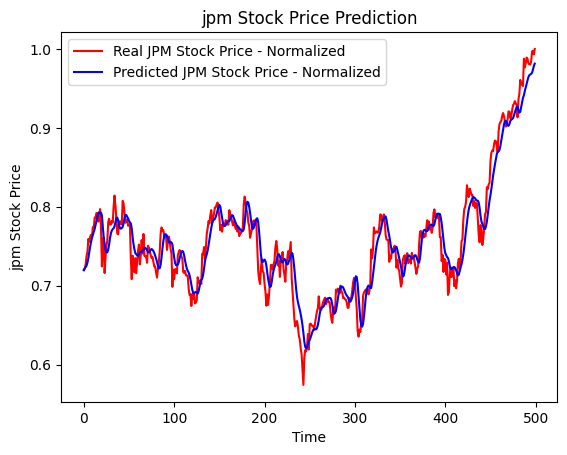

In [ ]:
plt.plot(real_normalized_stock_prices, color = 'red', label = 'Real JPM Stock Price - Normalized')
plt.plot(predicted_stock_prices, color = 'blue', label = 'Predicted JPM Stock Price - Normalized')
plt.title('jpm Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('jpm Stock Price')
plt.legend()
plt.show()